<a href="https://colab.research.google.com/github/thor4/neuralnets/blob/master/projects/1-CNN/step2-tilt_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate predictions from model
--- 

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov  8 15:18:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


## 1: Setup the model
This model was created using the `step1-train_vanilla_CNN_v2-cifar10.ipynb` Jupyter notebook. 
Run the cell to download a zip file from OSF then extract its contents into the newly created directory: `content/cifar10_gabors/`

In [6]:
# @title Download model

import requests, os
from zipfile import ZipFile

print("Start downloading and unzipping `CIFAR10 model fine-tuned on Gabors`...")
name = 'cifar10_gabors'
fname = f"{name}.zip"
url = f"https://osf.io/x8uve/download" #osf share link
r = requests.get(url, allow_redirects=True)
with open(fname, 'wb') as fh:
  fh.write(r.content) #download file

with ZipFile(fname, 'r') as zfile:
  zfile.extractall() #extract contents

if os.path.exists(fname):
  os.remove(fname) #delete zip file
else:
  print(f"The file {fname} does not exist")

print("Download completed.")

Start downloading and unzipping `VGG16 model`...
Download completed.


#### Load the model
Next, we load the model using Tensorflow

In [7]:
import tensorflow as tf 
import pandas as pd
tf.random.set_seed(42) #set random seed for reproducibility
model = tf.keras.models.load_model('cifar10_gabors') 
model.summary() #verify architecture

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 80)                2193440   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 81        
Total params: 2,193,521
Trainable params: 81
Non-trainable params: 2,193,440
_________________________________________________________________


## 2: Download & load datasets to test model with
Download the test datasets from OSF and extract the contents into the newly created directory: `content/datasets/`

In [8]:
# @title Download datasets

print("Start downloading and unzipping `18 test datasets`...")
name = 'model2_dset1-18_cond'
fname = f"{name}.zip"
url = f"https://osf.io/jkryf/download" #osf share link
r = requests.get(url, allow_redirects=True)
with open(fname, 'wb') as fh:
  fh.write(r.content) #download file

with ZipFile(fname, 'r') as zfile:
  zfile.extractall("datasets") #extract contents

if os.path.exists(fname):
  os.remove(fname) #delete zip file
else:
  print(f"The file {fname} does not exist")

print("Download completed.")

Start downloading and unzipping `18 test datasets`...
Download completed.


Load all 18 sets and use prefetch to streamline image loading

In [9]:
# @title Load datasets into tensorflow

from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 32 
IMG_SIZE = (160, 160) #forces a resize from 170x170 since VGG16 requires 224x224
AUTOTUNE = tf.data.AUTOTUNE #prompts the tf.data runtime to tune the value dynamically at runtime
def model2_init_sets(BATCH_SIZE, IMG_SIZE, AUTOTUNE):
    curr_dir = os.getcwd() 
    set1_dir = os.path.join(curr_dir, 'datasets/s1-t_0.1-c_0.3')
    set2_dir = os.path.join(curr_dir, 'datasets/s2-t_0.1-c_0.45')
    set3_dir = os.path.join(curr_dir, 'datasets/s3-t_0.1-c_1')
    set4_dir = os.path.join(curr_dir, 'datasets/s4-t_0.2-c_0.3')
    set5_dir = os.path.join(curr_dir, 'datasets/s5-t_0.2-c_0.45')
    set6_dir = os.path.join(curr_dir, 'datasets/s6-t_0.2-c_1')
    set7_dir = os.path.join(curr_dir, 'datasets/s7-t_0.4-c_0.3')
    set8_dir = os.path.join(curr_dir, 'datasets/s8-t_0.4-c_0.45')
    set9_dir = os.path.join(curr_dir, 'datasets/s9-t_0.4-c_1')
    set10_dir = os.path.join(curr_dir, 'datasets/s10-t_0.8-c_0.3')
    set11_dir = os.path.join(curr_dir, 'datasets/s11-t_0.8-c_0.45')
    set12_dir = os.path.join(curr_dir, 'datasets/s12-t_0.8-c_1')
    set13_dir = os.path.join(curr_dir, 'datasets/s13-t_1.6-c_0.3')
    set14_dir = os.path.join(curr_dir, 'datasets/s14-t_1.6-c_0.45')
    set15_dir = os.path.join(curr_dir, 'datasets/s15-t_1.6-c_1')
    set16_dir = os.path.join(curr_dir, 'datasets/s16-t_3.2-c_0.3')
    set17_dir = os.path.join(curr_dir, 'datasets/s17-t_3.2-c_0.45')
    set18_dir = os.path.join(curr_dir, 'datasets/s18-t_3.2-c_1')
    set2 = image_dataset_from_directory(set2_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
    set1 = image_dataset_from_directory(set1_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE) #3000 images 2 classes
    set3 = image_dataset_from_directory(set3_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
    set4 = image_dataset_from_directory(set4_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
    set5 = image_dataset_from_directory(set5_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
    set6 = image_dataset_from_directory(set6_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
    set7 = image_dataset_from_directory(set7_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE) #3000 images 2 classes
    set8 = image_dataset_from_directory(set8_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
    set9 = image_dataset_from_directory(set9_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
    set10 = image_dataset_from_directory(set10_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
    set11 = image_dataset_from_directory(set11_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
    set12 = image_dataset_from_directory(set12_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
    set13 = image_dataset_from_directory(set13_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE) #3000 images 2 classes
    set14 = image_dataset_from_directory(set14_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
    set15 = image_dataset_from_directory(set15_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
    set16 = image_dataset_from_directory(set16_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
    set17 = image_dataset_from_directory(set17_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
    set18 = image_dataset_from_directory(set18_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
    class_names = set1.class_names #extract class names loading function inferred from subdir's
    set1 = set1.prefetch(buffer_size=AUTOTUNE) 
    set2 = set2.prefetch(buffer_size=AUTOTUNE) 
    set3 = set3.prefetch(buffer_size=AUTOTUNE) 
    set4 = set4.prefetch(buffer_size=AUTOTUNE) 
    set5 = set5.prefetch(buffer_size=AUTOTUNE) 
    set6 = set6.prefetch(buffer_size=AUTOTUNE) 
    set7 = set7.prefetch(buffer_size=AUTOTUNE) 
    set8 = set8.prefetch(buffer_size=AUTOTUNE) 
    set9 = set9.prefetch(buffer_size=AUTOTUNE) 
    set10 = set10.prefetch(buffer_size=AUTOTUNE)
    set11 = set11.prefetch(buffer_size=AUTOTUNE)
    set12 = set12.prefetch(buffer_size=AUTOTUNE)
    set13 = set13.prefetch(buffer_size=AUTOTUNE)
    set14 = set14.prefetch(buffer_size=AUTOTUNE)
    set15 = set15.prefetch(buffer_size=AUTOTUNE)
    set16 = set16.prefetch(buffer_size=AUTOTUNE)
    set17 = set17.prefetch(buffer_size=AUTOTUNE)
    set18 = set18.prefetch(buffer_size=AUTOTUNE)
    return set1,set2,set3,set4,set5,set6,set7,set8,set9,set10,set11,set12,set13,set14,set15,set16,set17,set18,class_names

set1,set2,set3,set4,set5,set6,set7,set8,set9,set10,set11,set12,set13,set14,set15,set16,set17,set18,class_names = model2_init_sets(BATCH_SIZE, IMG_SIZE, AUTOTUNE)

Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


##3: Generate logits
First, we can define a function for generating logits from a dataset.

In [11]:
def get_logits(dataset, model):
    all_pred=tf.zeros([], tf.float64) #initialize array to hold all prediction logits (single element)
    all_labels=tf.zeros([], tf.float64) #initialize array to hold all actual labels (single element)
    for image_batch, label_batch in dataset.as_numpy_iterator():
        predictions = model.predict_on_batch(image_batch).flatten() #run batch through model and return logits
        all_pred = tf.experimental.numpy.append(all_pred, predictions)
        all_labels = tf.experimental.numpy.append(all_labels, label_batch)
    #tf.size(all_pred) #1335 elements, 1334 images + 1 placeholder 0 at beginning
    all_pred = all_pred[1:]
    all_labels = all_labels[1:]
    return all_pred,all_labels

Let's test it on the first dataset:

In [12]:
all_pred, all_labels = get_logits(set1,model)

In [13]:
all_pred.numpy()[:5] #first five logits, of 1000

array([ 0.60719788,  0.78077209,  1.13945186, -0.01594558,  1.18500745])

In [14]:
all_pred.numpy().mean() #mean stays static for up to 7-8 digits

0.6035675281286239

In [15]:
all_pred.numpy().shape

(1000,)

In [16]:
all_labels.numpy()[:5] #first five labels, of 1000

array([0., 0., 0., 0., 0.])

Looks good. Now, we can add it to a pandas dataframe.

In [17]:
df = pd.DataFrame({'Logits':all_pred.numpy(),'Labels':all_labels.numpy()})
df.head()

,Logits,Labels
0,0.607198,0.0
1,0.780772,0.0
2,1.139452,0.0
3,-0.015946,0.0
4,1.185007,0.0


Next, let's process all 18 datasets. We will stack each sets' 1,000 logits in a single dataframe. The resulting dataframe will have 18,000 logits resulting from vertically stacking the logits for set1, set 2, .., set18.

In [18]:
df = pd.DataFrame(columns=['Logits','Labels']) #initialize dataframe
all_sets = [set1,set2,set3,set4,set5,set6,set7,set8,set9,set10,set11,set12,set13,set14,set15,set16,set17,set18]
for dataset in all_sets: #run for all sets:
    all_pred, all_labels = get_logits(dataset, model)
    df = pd.concat([df, pd.DataFrame({'Logits':all_pred.numpy(),
                                      'Labels':all_labels.numpy()})], 
                   axis=0, ignore_index=True) #append logits & labels to dataframe

Confirm logits and labels for all 18,000 images were saved:

In [19]:
df.shape

(18000, 2)

Finally, we can save the dataframe as an excel file to disk.

In [20]:
logits_excel_filepath = os.path.join(os.getcwd(), 'logits_cifar10.xlsx') #prep path to save to

df.to_excel(logits_excel_filepath, index=False) #save to disk

##4: Visualize the logits
First, let's the class names and insert them into the dataframe for visualization:

In [30]:
class_names

['cclock', 'clock']

In [31]:
df.replace({'Labels': {0: class_names[0], 1: class_names[1]}}, inplace=True) #change 0/1 classes to cclock & clock

We can plot a histogram of the logits across all the datasets using Seaborn. Counterclockwise (cclock) tilts are represented as blue and clockwise (clock) tilts are represented as orange.

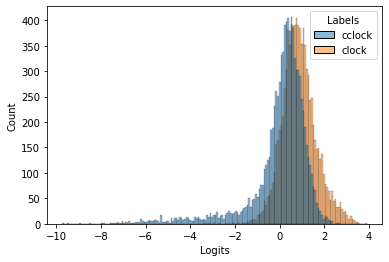

In [32]:
import seaborn as sns
sns.histplot(data=df, x="Logits", hue="Labels")

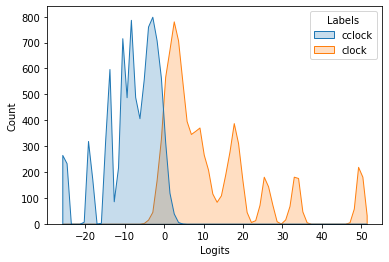

In [ ]:
sns.histplot(data=df, x="Logits", hue="Labels", element="poly") #old model v1

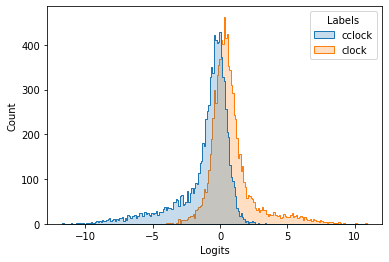

In [ ]:
sns.histplot(data=df, x="Logits", hue="Labels", element="step") #v1 model

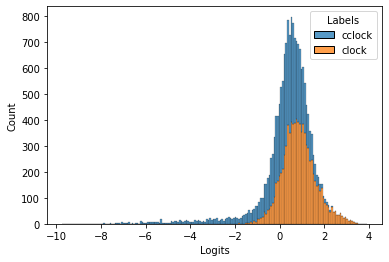

In [33]:
sns.histplot(data=df, x="Logits", hue="Labels", multiple="stack") #v1 model

This one looks best. Let's increase its size and save the figure as a high resolution transparent png.

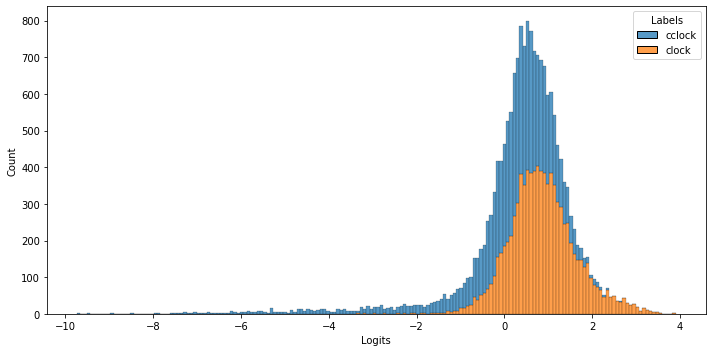

In [34]:
import matplotlib.pyplot as plt
lfig = sns.histplot(data=df, x="Logits", hue="Labels", multiple="stack")
fig=plt.gcf()
fig.set_size_inches(10, 5)
plt.tight_layout()
plt.savefig('logits_cifar10.png', transparent=True, dpi=300)